<a href="https://colab.research.google.com/github/seungmindavid/Kaggle-Projects/blob/master/wGAN-gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pathlib
import torchvision


# Wasserstein Generative Adversarial Networks (WGANs)

- JS Divergence has gradient issues which lead to unstable training. WGAN bases its loss from Wasserstein Distance.

$\text{max}_{||f|| \leq 1}\mathbb{E}_{x \sim \mathbb{P}_r}[f(x)] - \mathbb{E}_{x \sim \mathbb{P}_θ}[f(x)]$

Critic: maximize separation

Generator: minimize separation.




### Architecture guidelines for stable Deep Convolutional GANs ("Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Network - Alec & Luke & Soumith 2016)
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator)
- Use batchnorm in both the generator and the discriminator
- Remove fully connected hidden layers for deeper architectures
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers


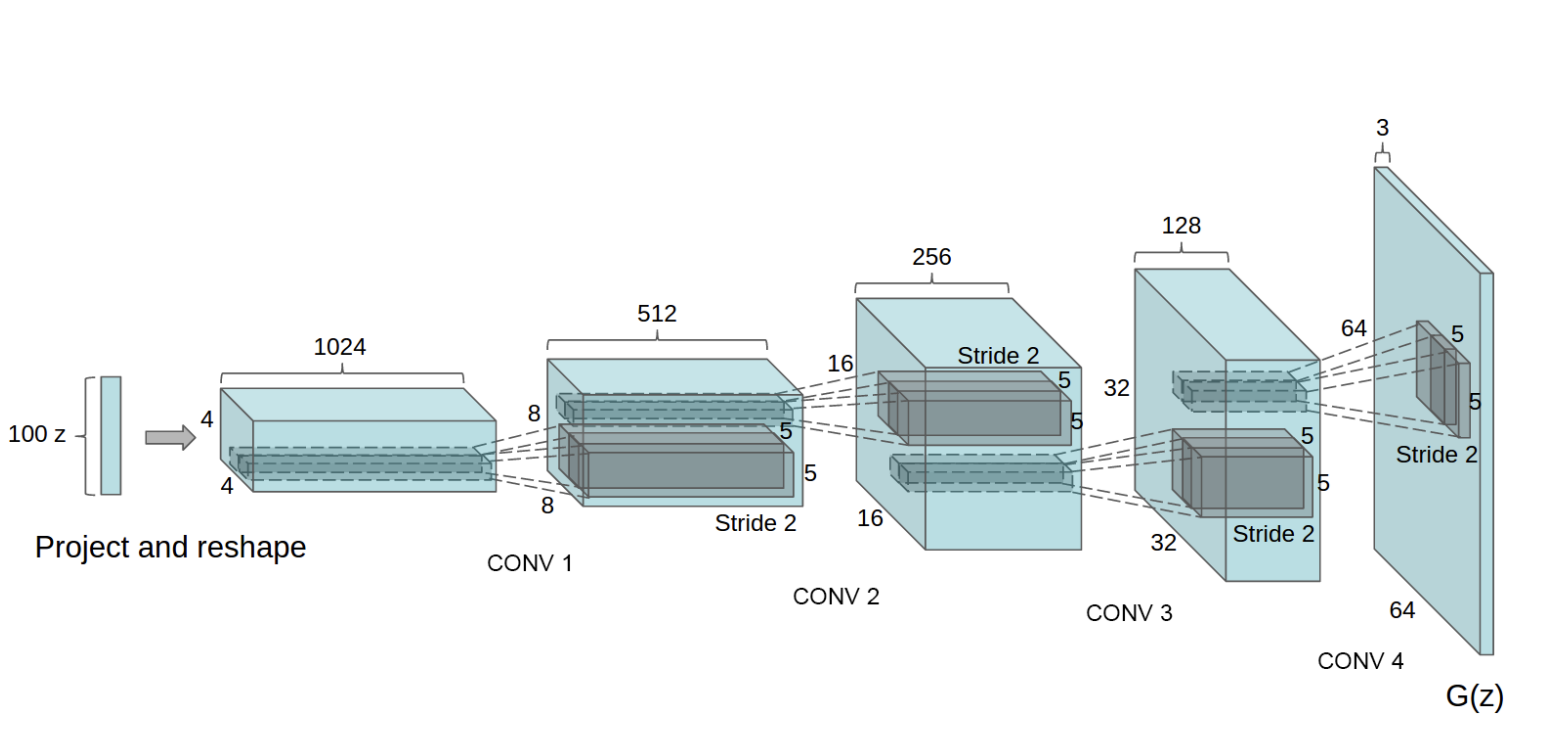

# Loading Dataset (MNIST)
Batch size
- Train dataset: 128 batch size
- Test dataset: 10 batch

## Details of adversarial training
- batch size: 128
- All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02
- In the LeakyReLU, the slope of the leak was set to 0.2 in all models
- Adam optimizer with tuned hyperparameters learning rate 0.0002, Beta (0.5, 0.99)
- Z (latent): 100 dimensional uniform distribution

In [2]:
batch_size_train = 128
batch_size_test = 10
img_size = 64

# mean and standard deviation for mnist dataset: 0.1307, 0.3081
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download= True, transform=transform),
    batch_size = batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size = batch_size_test, shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 137551773.32it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 17811453.29it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19450701.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8272048.97it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Loss Construction
- Discriminator: $\text{min}_G \text{max}_D \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1-D(G(z)))]$, with fixed G (Generator).
- $L_{dis} = BCE(D(x), 1) + BCE(D(G(z)), 0)$


- Generator: $\text{max}_G\mathbb{E}_{z\sim p_{z}(z)}[log(D(G(z)))]$ which is equal to $\text{min}_G\mathbb{E}_{z\sim p_{z}(z)}[1-log(D(G(z)))]$ with fixed D
(Discriminator)
- $L_{gen} = -BCE(D(G(z)), 0) = BCE(D(G(z)), 1)$

- The rationale for transitioning the generator from a minimization objective to a maximization objective lies in the common observation that, initially, the discriminator typically exhibits superior performance over the generator. This phenomenon lead $D(G(z))$ to outproduce 0. Particularly, when $x=0$, $log(x)$ has steeper gradient than $log(1-x)$, which faciliates the more efficient training of the Generator.


In [ ]:
BCE = nn.BCELoss()

# Building Discriminator & Generator
- [Linear → LeakyReLU] × 4 using increasing linear layer sizes, e.g., 128 → 256 → 512 → 1024 → (28 ∗ 28). LeakyReLU often replaces the ReLU non-linearity in direct generative models both in convolutional generators and fully connected generators.
- Generator: 128 → 256 → 512 → 1024 → (28 ∗ 28)
- Discriminator: (28 ∗ 28) → 1024 → 512 → 256 → 128 -> 1

In [11]:
class Critic(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Critic, self).__init__()
    self.disc = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        self._block(out_channels, out_channels*2, kernel_size=4, stride=2, padding=1),
        self._block(out_channels*2, out_channels*4, kernel_size=4, stride=2, padding=1),
        self._block(out_channels*4, out_channels*8, kernel_size=4, stride=2, padding=1),
        nn.Conv2d(out_channels*8, 1, kernel_size=4, stride=2, padding=0), # last layer 1 channel
        #nn.Sigmoid(), # at last, use sigmoid
    )
  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.LayerNorm2d(out_channels, affine=True),
        #nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )
  def forward(self, x):
    return self.disc(x)



In [5]:
class Generator(nn.Module):
  def __init__(self, z_dim, in_channels, out_channels):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        self._block(z_dim, out_channels*16, kernel_size=4, stride=1, padding=0), # 1x1 -> 4x4
        self._block(out_channels*16, out_channels*8, kernel_size=4, stride=2, padding=1),
        self._block(out_channels*8, out_channels*4, kernel_size=4, stride=2, padding=1),
        self._block(out_channels*4, out_channels*2, kernel_size=4, stride=2, padding=1),
        nn.ConvTranspose2d(out_channels*2, in_channels, kernel_size=4, stride=2, padding=1), # last layer 1 channel
        nn.Tanh(), # at last, use sigmoid
    )
  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(0.2),
    )
  def forward(self, x):
    return self.gen(x)





- All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02

In [6]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal(m.weight.data, 0, 0.02)

# Training WGAN (without gradient penalty)


In [7]:
# # Save model
# saved_params_path = "./saved_params_dcgan"
# pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

# # Hyperparameters
# device = "cpu"
# lr = 2e-4
# z_dim = 100
# image_dim = 64
# num_epochs = 10
# in_channel = 1
# out_channel = 64
# critic_iteration = 5
# weight_clip = 0.01


# Gen_Loss = []
# Cri_Loss = []

# cri = Critic(in_channel, out_channel).to(device)
# initialize_weights(cri)
# cri_optim = optim.RMSProp(cri.parameters(), lr=lr)

# gen = Generator(z_dim, in_channel, out_channel,).to(device)
# initialize_weights(gen)
# gen_optim = optim.RMSProp(gen.parameters(), lr=lr)


# for epoch in range(num_epochs):
#   for i, data in enumerate(train_loader, 0):
#     real, labels = data
#     real = real.to(device)
#     batch_size = real.shape[0]

#     # Train Critic
#     for _ in range(critic_iteration):
#       noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
#       fake = gen(noise).reshape
#       D_x = cri(real).reshape(-1)
#       D_G_z = cri(fake).reshape(-1)
#       L_critic = -(torch.mean(D_x) - torch.mean(D_G_z))
#       cri.zero_grad()
#       L_critic.backward(retrain_graph=True)
#       cri_optim.step()

#       for p in cri.parameters():
#         p.data.clamp_(-weight_clip, weight_clip)

#     # Train Generator: minE[D(G(z))]
#     D_G_z = cri(fake).reshape(-1)
#     L_generator = -torch.mean(D_G_z)
#     gen.zero_grad()
#     L_generator.backward()
#     gen_optim.step()

#     print(f"{i}-th batch size {batch_size} with d_loss: {D_loss.item()}, g_loss: {G_loss.item()}")

#   print(f"Epoch [{epoch}/{num_epochs}]\
#         Critic Loss: {D_loss.item():.4f}, loss G: {G_loss.item():.4f}")
#   Gen_Loss.append(G_loss.item())
#   Cri_Loss.append(D_loss.item())
#   torch.save(cri.state_dict(), f'{saved_params_path}/critic_{epoch}.pth')
#   torch.save(gen.state_dict(), f'{saved_params_path}/generator_{epoch}.pth')


According to paper, Weight clipping is a clearly terrible way to enforce a ipschitz constraint.

Algorithm: WGAN with gradient penalty. We use default of $\lambda = 10, n_{critic}=5, α=0.0001, β_1 = 0, β_2 = 0.9, ϵ \sim \mathbb{U}[0,1]$

In [10]:
def gradient_penalty(critic, real, fake, device = "cpu"):
  batch_size, channels, height, width = real.shape
  epsilon = torch.rand((batch_size, 1, 1, 1)).repeat(1, channels, height, width).to(device)
  interpolated_images =  real * epsilon + fake * (1-epsilon)

  mixed_scores = critic(interpolated_images)

  gradient = torch.autograd.grad(
      inputs = interpolated_images,
      outputs= mixed_scores,
      grad_outputs= torch.ones_like(mixed_scores),
      create_graph=True,
      retain_graph =True,
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm -1)**2)
  return gradient_penalty

In [8]:
for i, data in enumerate(train_loader, 0):
  real, labels = data

In [9]:
real.shape

torch.Size([96, 1, 64, 64])

In [ ]:
# Save model
saved_params_path = "./saved_params_dcgan"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

# Hyperparameters
device = "cpu"
lr = 1e-4
z_dim = 100
image_dim = 64
num_epochs = 10
in_channel = 1
out_channel = 64
critic_iteration = 5
lambda_gp = 10
#weight_clip = 0.01


Gen_Loss = []
Cri_Loss = []

cri = Critic(in_channel, out_channel).to(device)
initialize_weights(cri)
cri_optim = optim.Adam(cri.parameters(), lr=lr, betas = (0.0, 0.9))

gen = Generator(z_dim, in_channel, out_channel,).to(device)
initialize_weights(gen)
gen_optim = optim.Adam(gen.parameters(), lr=lr, betas = (0.0, 0.9))


for epoch in range(num_epochs):
  for i, data in enumerate(train_loader, 0):
    real, labels = data
    real = real.to(device)
    batch_size = real.shape[0]

    # Train Critic
    for _ in range(critic_iteration):
      noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
      fake = gen(noise).reshape
      D_x = cri(real).reshape(-1)
      D_G_z = cri(fake).reshape(-1)
      gp = gradient_penalty(cri, real, fake, device = device)
      L_critic = (-(torch.mean(D_x) - torch.mean(D_G_z)) + lambda_gp * gp)
      cri.zero_grad()
      L_critic.backward(retrain_graph=True)
      cri_optim.step()

    # Train Generator: minE[D(G(z))]
    D_G_z = cri(fake).reshape(-1)
    L_generator = -torch.mean(D_G_z)
    gen.zero_grad()
    L_generator.backward()
    gen_optim.step()

    print(f"{i}-th batch size {batch_size} with d_loss: {D_loss.item()}, g_loss: {G_loss.item()}")

  print(f"Epoch [{epoch}/{num_epochs}]\
        Critic Loss: {D_loss.item():.4f}, loss G: {G_loss.item():.4f}")
  Gen_Loss.append(G_loss.item())
  Cri_Loss.append(D_loss.item())
  torch.save(cri.state_dict(), f'{saved_params_path}/critic_{epoch}.pth')
  torch.save(gen.state_dict(), f'{saved_params_path}/generator_{epoch}.pth')


In [ ]:
i = 1
batchss = 124
print(f"{i}-th batch size {batchss}")

1-th batch size 124


# Plotting Critic vs Generator

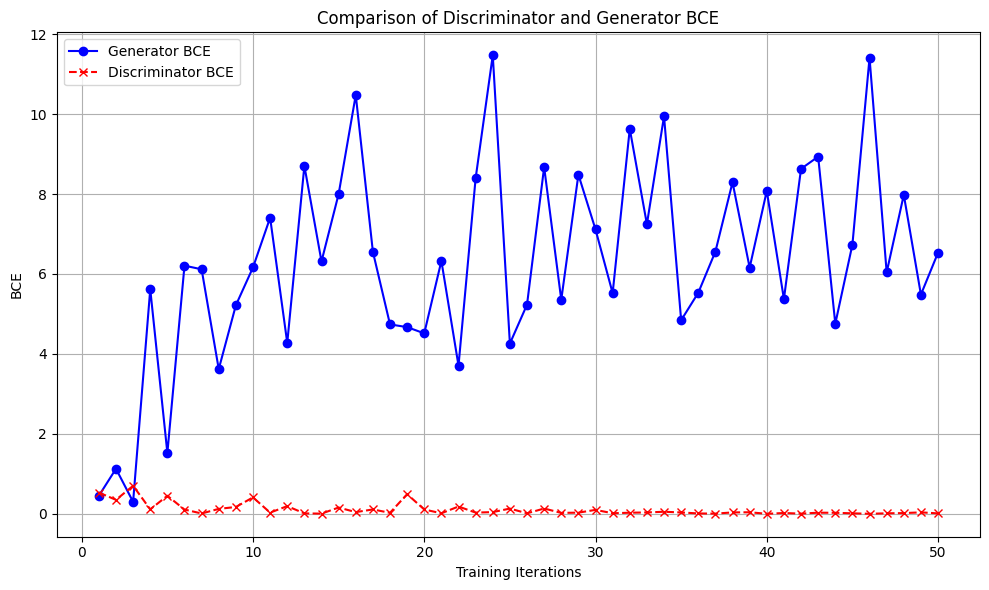

In [ ]:
import matplotlib.pyplot as plt

# Define the x-axis (training iteration or epoch numbers)
iterations = range(1, len(Gen_Loss) + 1)

# Plot the loss curves for both models
plt.figure(figsize=(10, 6))
plt.plot(iterations, Gen_Loss, label='Generator BCE', marker='o', linestyle='-', color='b')
plt.plot(iterations, Dis_Loss, label='Critic BCE', marker='x', linestyle='--', color='r')

# Add labels and a legend
plt.xlabel('Training Iterations')
plt.ylabel('BCE')
plt.title('Comparison of Critic and Generator BCE')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

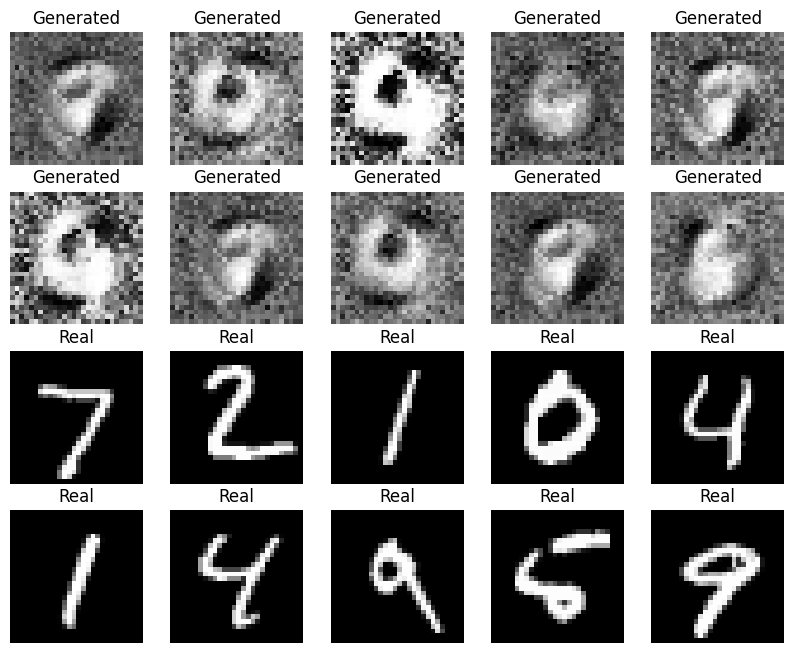

In [ ]:
#gen.load_state_dict(torch.load(f"{saved_params_path}/{epoch}.pth"))
gen.eval()

fixed_noise = torch.randn((batch_size_test, z_dim)).to(device)
generated_images = gen(fixed_noise)

real_images, _ = next(iter(test_loader))
real_images = real_images.view(real_images.size(0), -1).numpy()

import matplotlib.pyplot as plt

# Display generated and real images in a 4x4 grid
plt.figure(figsize=(10, 10))

for i in range(20):
    plt.subplot(5, 5, i + 1)
    if i < 10:
        plt.imshow(generated_images[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
        plt.title('Generated')
    else:
        plt.imshow(real_images[i - 10].reshape(28, 28), cmap='gray')
        plt.title('Real')
    plt.axis('off')

